In [30]:
%load_ext autoreload
%autoreload 2

import sys
import cv2
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import random

project_path = Path.cwd().parent.parent
model_path = project_path / "model"
src_path = project_path / "python" / "src"
data_path = project_path / "data"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Add the absolute path to the covid-chestray-dataset to be able to load the images
covid_dataset = Path.cwd().parent.parent.parent / 'covid-chestxray-dataset'
covid_images_dir = covid_dataset / 'images'
list(covid_dataset.glob('*'))

[PosixPath('/home/axel/workspace/covid-chestxray-dataset/.gitignore'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/README.md'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/.git'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/docs'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/metadata.csv'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/images'),
 PosixPath('/home/axel/workspace/covid-chestxray-dataset/CONTRIBUTING.md')]

In [14]:
metadata = pd.read_csv(covid_dataset / 'metadata.csv')
print(metadata.shape)
metadata.head()

(152, 17)


,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
metadata.finding.value_counts()

COVID-19         127
SARS              11
Streptococcus      6
ARDS               4
Pneumocystis       2
No Finding         2
Name: finding, dtype: int64

In [114]:
metadata.view.value_counts()

PA           96
Axial        20
L            12
AP           11
AP Supine    10
Coronal       3
Name: view, dtype: int64

### Load images

In [117]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title, fontsize = 40)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [93]:
## Load images into a numpay array of shape 152 (nb images) x 224 x 224
H_IMAGE = 224
W_IMAGE = 224
NB_IMAGE = metadata.shape[0]


images = np.zeros((NB_IMAGE, H_IMAGE, W_IMAGE))

# loop over all filename in the metadata, load image with pillow -> turn it into a numpy array -> transform in grayscale
data = [cv2.resize(np.asarray(Image.open(covid_images_dir / filename)), dsize=(H_IMAGE, W_IMAGE), interpolation=cv2.INTER_CUBIC) for filename in metadata.filename]
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim > 2 else image for image in data]

# Save all images in our numpy matrix
for idx, image in enumerate(gray_images):
    images[idx, :, :] += image

print(images.shape)

In [104]:
encoder_labels = OrdinalEncoder().fit(metadata.finding.values.reshape(-1, 1))
labels = encoder_labels.transform(metadata.finding.values.reshape(-1, 1)).flatten()
print(labels[:5])

modalities = metadata.modality.values
print(modalities[:5])

[1. 1. 1. 1. 1.]
['X-ray' 'X-ray' 'X-ray' 'X-ray' 'X-ray']


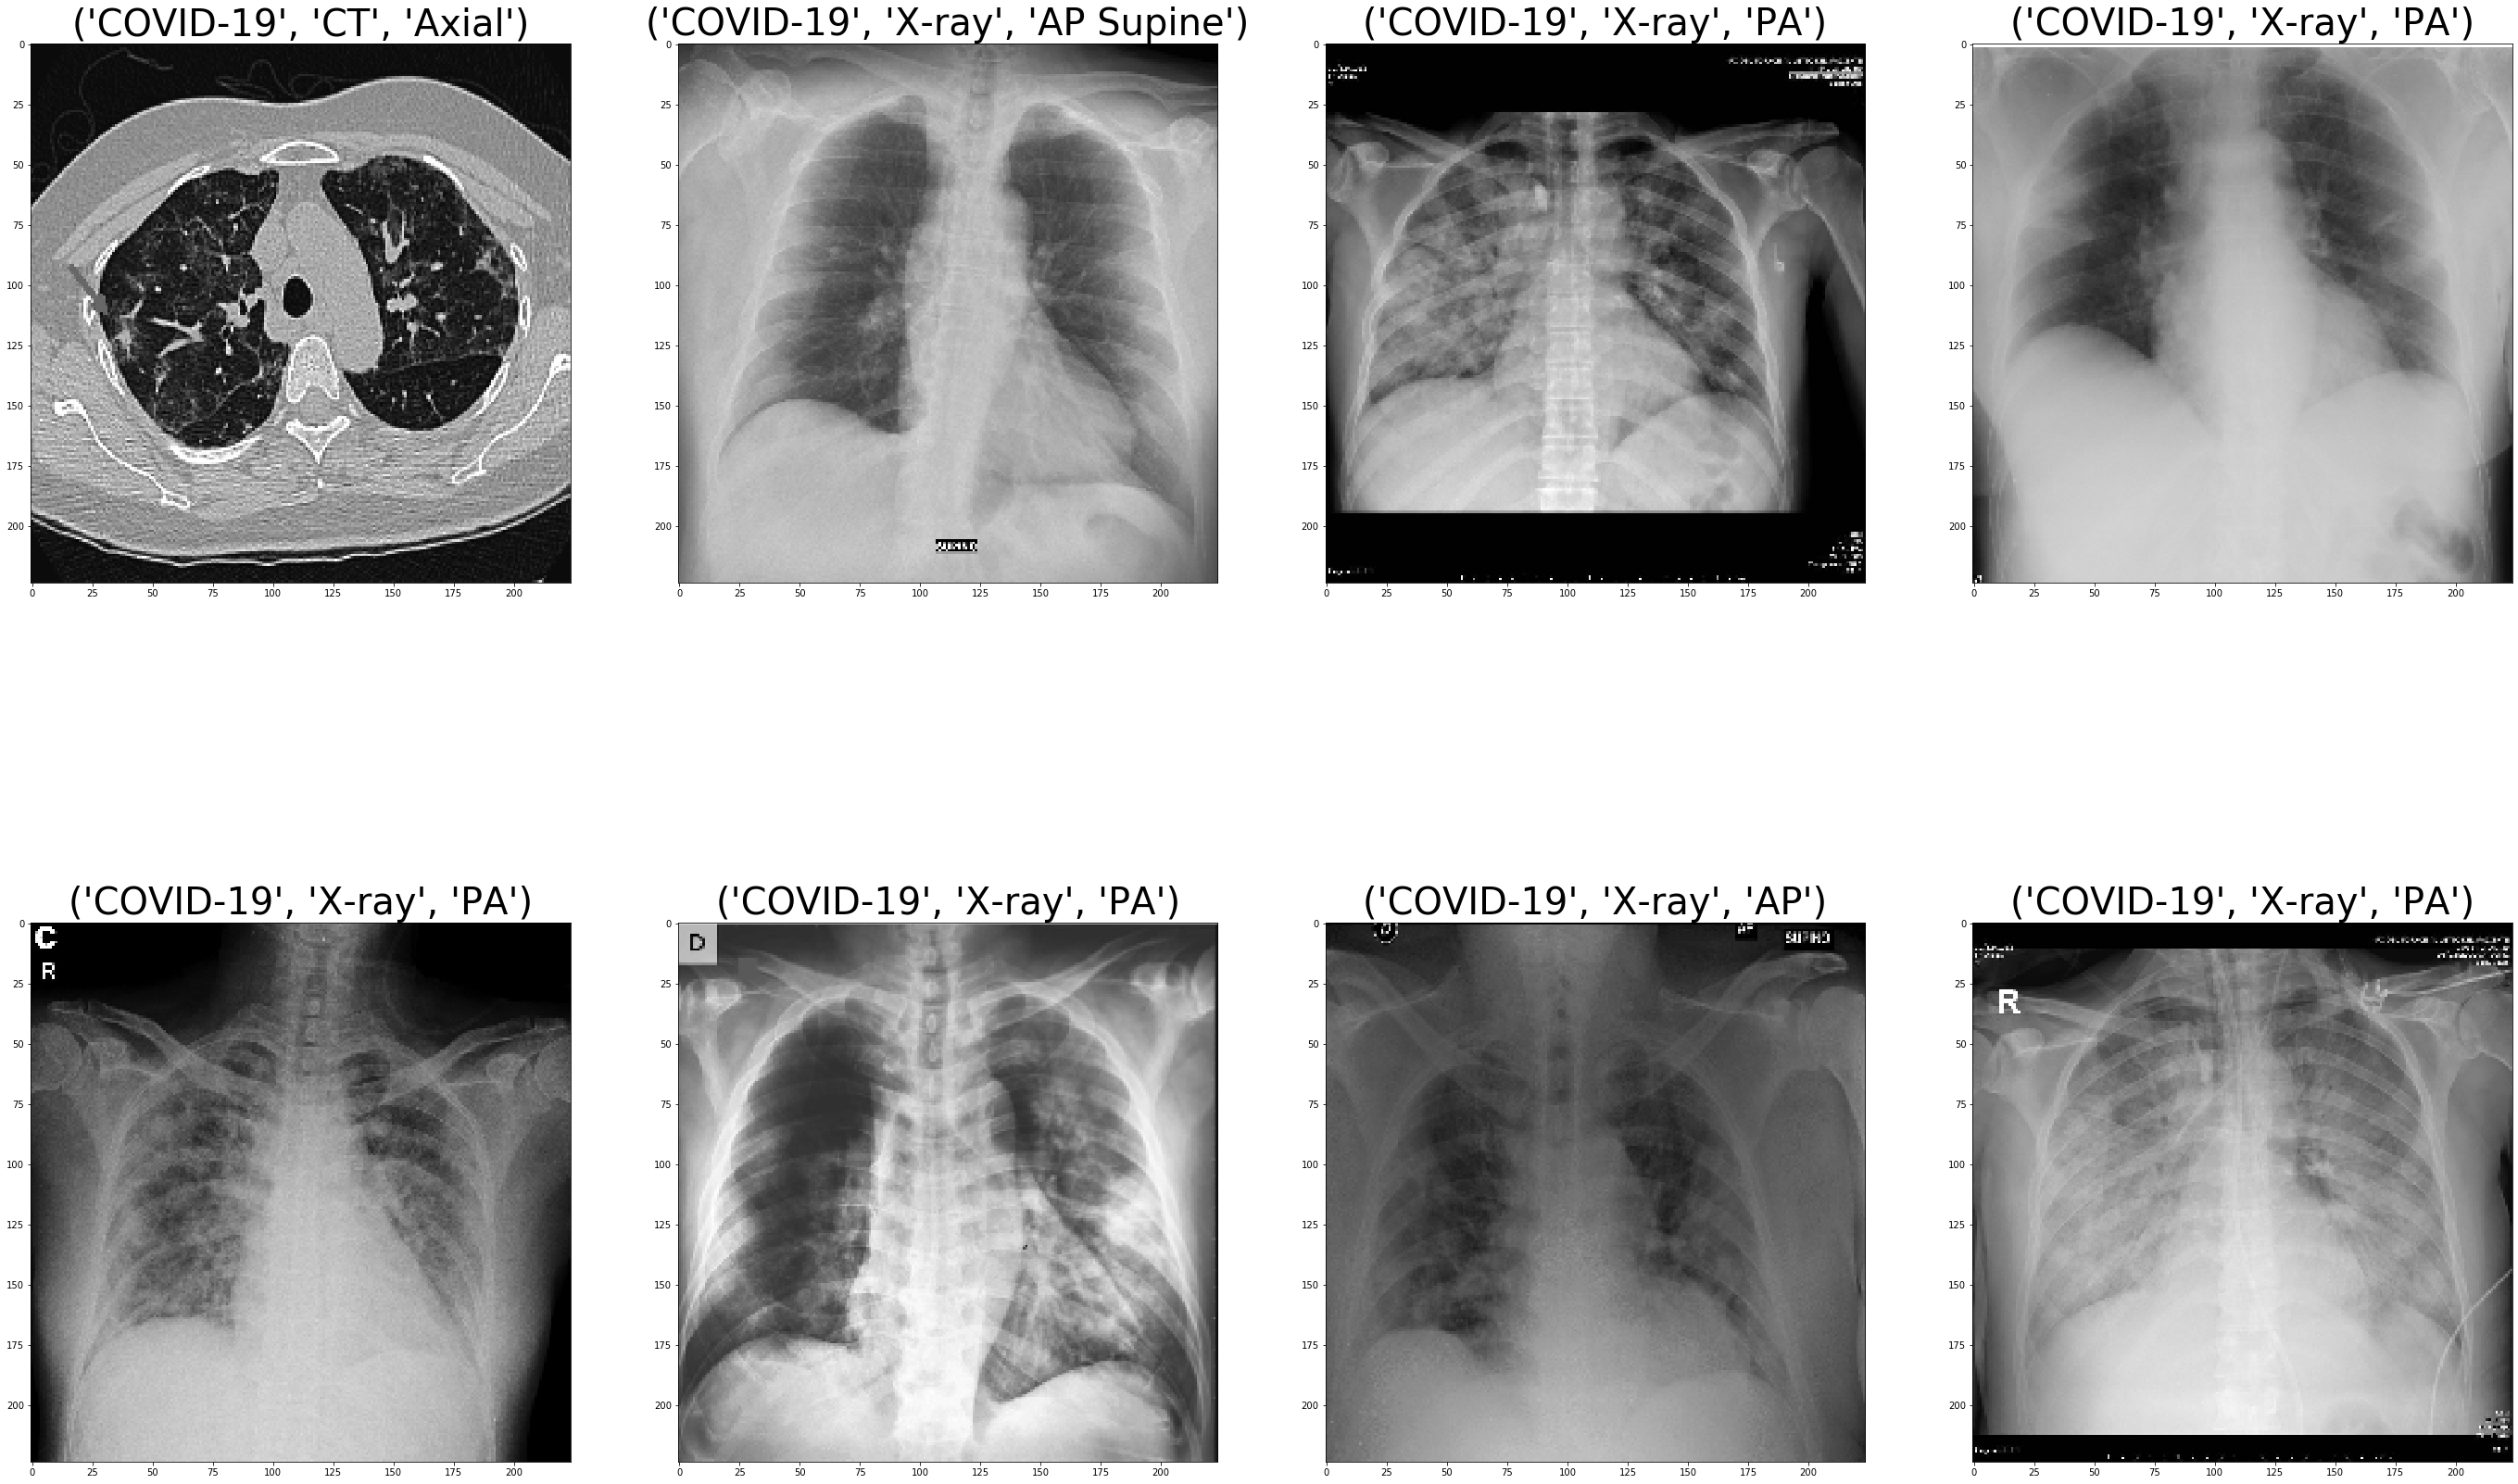

In [120]:
indices = random.choices(list(range(NB_IMAGE)), k=8)
diseas = metadata.finding.values[indices]
modalities = metadata.modality.values[indices]
views = metadata.view.values[indices]

titles = [(label, modality, view) for label, modality, view in zip(diseas, modalities, views)]

show_images(images[indices, :, :], cols=2, titles=titles)